In this notebook we will demonstrate how to interpret a Deep Learning Model using [LIME](https://github.com/marcotcr/lime)(local interpretable model-agnostic explanations), a python package for explaining machine learning classifiers. 

In [1]:
!pip install tensorflow==1.14.0

We will be building an LSTM model with an embedding layer trained on the fly. We will be following all the preprocessing steps as in the [DeepNN_Example.ipynb](https://github.com/practical-nlp/practical-nlp/blob/master/Ch4/DeepNN_Example.ipynb) notebook in this repo.

In [2]:
import tensorflow as tf
from tensorflow import keras
import os
import re
import pandas as pd

#helper functions to lead the data
def load_directory_data(directory):
    data = {}
    data["sentence"] = []
    data["sentiment"] = []
    for file_path in os.listdir(directory):
        with tf.io.gfile.GFile(os.path.join(directory, file_path), "r") as f:
            data["sentence"].append(f.read())
            data["sentiment"].append(re.match("\d+_(\d+)\.txt", file_path).group(1))
    return pd.DataFrame.from_dict(data)

# Merge positive and negative examples, add a polarity column and shuffle.
def load_dataset(directory):
    pos_df = load_directory_data(os.path.join(directory, "pos"))
    neg_df = load_directory_data(os.path.join(directory, "neg"))
    pos_df["polarity"] = 1
    neg_df["polarity"] = 0
    return pd.concat([pos_df, neg_df]).sample(frac=1).reset_index(drop=True)

def download_and_load_datasets(force_download=False):
    dataset = tf.keras.utils.get_file(
      fname="aclImdb.tar.gz", 
      origin="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz", 
      extract=True)

    train_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                       "aclImdb", "train"))
    test_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                      "aclImdb", "test"))
  
    return train_df, test_df

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [3]:
try:
    from google.colab import files
    
    if not os.path.exists('aclImdb'):
        train,test = download_and_load_datasets()
    else:
        train = load_dataset('aclImdb/train')
        test = load_dataset('aclImdb/test')
    
except ModuleNotFoundError:
    if not os.path.exists('Data/aclImdb'):
        train,test = download_and_load_datasets()
    else:
        train = load_dataset('Data/aclImdb/train')
        test = load_dataset('Data/aclImdb/test')

In [4]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, LSTM
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.initializers import Constant
from sklearn.metrics import accuracy_score


MAX_SEQUENCE_LENGTH = 1000
MAX_NUM_WORDS = 20000 
EMBEDDING_DIM = 100 
VALIDATION_SPLIT = 0.2

vocab_size = 20000  # Max number of different word, i.e. model input dimension
maxlen = 1000 # Max number of words kept at the end of each text

In [5]:
train.columns

Index(['sentence', 'sentiment', 'polarity'], dtype='object')

In [6]:
train_texts = train['sentence'].values
train_labels = train['polarity'].values
test_texts = test['sentence'].values
# test_labels = test['polarity'].values

labels_index = {'pos':1, 'neg':0} 

In [7]:
test.columns

Index(['sentence', 'sentiment', 'polarity'], dtype='object')

In [8]:
test_labels = test['polarity'].values
test_labels

array([1, 0, 1, ..., 0, 1, 0])

We need to design an sklearn pipeline with our model.
What is a pipeline?<br>

**Transformer** in scikit-learn - some class that have fit and transform method, or fit_transform method.

**Predictor** - some class that has fit and predict methods, or fit_predict method.

**Pipeline** is just an abstract notion, it's not some existing ml algorithm. Often in ML tasks you need to perform sequence of different transformations (find set of features, generate new features, select only some good features) of raw dataset before applying final estimator. Pipeline gives you a single interface for all 3 steps of transformation and resulting estimator. It encapsulates transformers and predictors inside

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.pipeline import TransformerMixin
from sklearn.base import BaseEstimator


class TextsToSequences(Tokenizer, BaseEstimator, TransformerMixin):
    """ Sklearn transformer to convert texts to indices list 
    (e.g. [["the cute cat"], ["the dog"]] -> [[1, 2, 3], [1, 4]])"""
    def __init__(self,  **kwargs):
        super().__init__(**kwargs)
        
    def fit(self, texts, y=None):
        self.fit_on_texts(texts)
        return self
    
    def transform(self, texts, y=None):
        return np.array(self.texts_to_sequences(texts))
        
sequencer = TextsToSequences(num_words=vocab_size)




class Padder(BaseEstimator, TransformerMixin):
    """ Pad and crop uneven lists to the same length. 
    Only the end of lists longernthan the maxlen attribute are
    kept, and lists shorter than maxlen are left-padded with zeros
    
    Attributes
    ----------
    maxlen: int
        sizes of sequences after padding
    max_index: int
        maximum index known by the Padder, if a higher index is met during 
        transform it is transformed to a 0
    """
    def __init__(self, maxlen=500):
        self.maxlen = maxlen
        self.max_index = None
        
    def fit(self, X, y=None):
        self.max_index = pad_sequences(X, maxlen=self.maxlen).max()
        return self
    
    def transform(self, X, y=None):
        X = pad_sequences(X, maxlen=self.maxlen)
        X[X > self.max_index] = 0
        return X

padder = Padder(maxlen)

We will only train for 2 epochs. A better model could be trained with more epochs and early stopping.

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.pipeline import make_pipeline

batch_size = 64
max_features = vocab_size + 1

#Training an LSTM with embedding on the fly
def create_model(max_features):
    """ Model creation function: returns a compiled LSTM"""


    rnnmodel = Sequential()
    rnnmodel.add(Embedding(MAX_NUM_WORDS, 128))
    rnnmodel.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
    rnnmodel.add(Dense(1, activation='sigmoid'))
    rnnmodel.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    return rnnmodel


# Use Keras Scikit-learn wrapper to instantiate a LSTM with all methods
# required by Scikit-learn for the last step of a Pipeline
sklearn_lstm = KerasClassifier(build_fn=create_model, epochs=2, batch_size=32, 
                               max_features=max_features, verbose=1)

# Build the Scikit-learn pipeline
pipeline = make_pipeline(sequencer, padder, sklearn_lstm)

pipeline.fit(train_texts, train_labels);

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/2
25000/25000 [==============================] - 1590s 64ms/sample - loss: 0.4606 - acc: 0.7860
Epoch 2/2
25000/25000 [==============================] - 1592s 64ms/sample - loss: 0.3082 - acc: 0.8769


In [11]:
y_preds = pipeline.predict(test_texts)

25000/25000 [==============================] - 190s 8ms/sample


In [14]:
print('Test accuracy: {:.2f} %'.format(100*accuracy_score(y_preds, test_labels)))

Test accuracy: 81.98 %


In [16]:
!pip install lime

     |████████████████████████████████| 276kB 9.0MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp37-none-any.whl size=283858 sha256=142a70cba58d7f94457f79f6fc14bb59e296602f09a886c9aad67b91e467fe0d
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


Sample 11: last 1000 words (only part used by the model)
--------------------------------------------------
It's painfully obvious that the people who made this "movie" have never seen such brilliant spoofs as "The Naked Gun" and "Hot Shots". This movie is terrible, and so are the actors. They wouldn't know acting even if it hit them in the face, as I felt like doing while watching this total pile of rubbish.<br /><br />The movie is stupid and has no humor in it what so ever. I'm SURE that I could make a better movie with my friends. To me it's amazing that a movie can fail this much. Not a single clever or funny line. No trace of intelligence behind it. It's a pathetic movie and I'd like to meet the person who actually likes this movie. Yuck!
--------------------------------------------------
1/1 [==============================] - 0s 100ms/sample
Probability(positive) = 0.021764357
True class: negative
5000/5000 [==============================] - 38s 8ms/sample


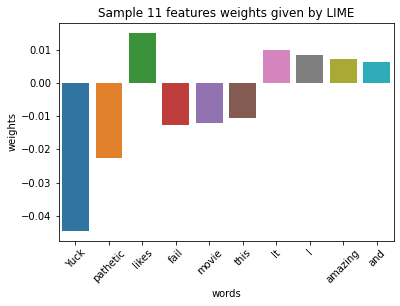

In [17]:
# We choose a sample from test set
idx = 11
text_sample = test_texts[idx]
class_names = ['negative', 'positive']

print('Sample {}: last 1000 words (only part used by the model)'.format(idx))
print('-'*50)
print(" ".join(text_sample.split()[-1000:]))
print('-'*50)
print('Probability(positive) =', pipeline.predict_proba([text_sample])[0,1])
print('True class: %s' % class_names[test_labels[idx]])



import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from collections import OrderedDict
from lime.lime_text import LimeTextExplainer

explainer = LimeTextExplainer(class_names=class_names)
explanation = explainer.explain_instance(text_sample, pipeline.predict_proba, num_features=10)

weights = OrderedDict(explanation.as_list())
lime_weights = pd.DataFrame({'words': list(weights.keys()), 'weights': list(weights.values())})

sns.barplot(x="words", y="weights", data=lime_weights);
plt.xticks(rotation=45)
plt.title('Sample {} features weights given by LIME'.format(idx));

We have used the LIME interpretation to provide explanations for a recurrent neural network. Looking at the graph we understand that the sentence is negative and the word "worst" affects it the most.

